In [1]:
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np

Let's first think abstractly about the interface we'll want for making use of our neural network.
We'll likely want:
- flexible number of input and output neurons as well as hidden layer count
- different activation function (ReLU, Sigmoid etc.)
- different loss functions

Further, we clearly need to abstract the inner definition of the activation function to the following:

In [2]:
class Activation(ABC):
    @abstractmethod
    def __call__(self, x):
        pass

    @abstractmethod
    def derivative(self, x):
        pass

Which we can give life with, e.g., the following functions:

In [4]:
class Linear(Activation):
    def __call__(self, x):
        return x
    def derivative(self, x):
        return 1
    
class ReLU(Activation):
    def __call__(self, x):
        return np.maximum(0, x)

    def derivative(self, x):
        if not isinstance(x, np.ndarray):
            return 0 if x < 0 else 1
        x = x.copy()
        neg = x < 0
        x[neg] = 0
        x[~neg] = 1
        return x

class Softmax(Activation):
    def __call__(self, x):
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps)

    def derivative(self, x):
        pass

A loss function will need a similar interface. E.g. the squared loss:

In [5]:
class Loss(ABC):
    @abstractmethod
    def __call__(self, true_labels, predictions):
        pass

    @abstractmethod
    def derivative(self, true_labels, predictions):
        pass

class SquaredLoss(Loss):
    def __call__(self, true_labels, predictions):
        diff = true_labels - predictions
        loss = diff.T @ diff
        return loss/2
    
    def derivative(self, true_labels, predictions):
        return predictions - true_labels 

When we think of layer, it is characterised by it's number of neurons and the activation function we apply on it. <br>
Additionally, we'll need to store the pre- and post-activation vectors for backpropagation as well as the resulting gradient of the layer. <br>
To not confuse ourselves with indices, our neural network later will provide the next layer as well as the weight object (that will forward this layer to the next) corresponding to this layer. <br>
Let's code that up:

In [6]:
class Layer:
    def __init__(self, neuron_count: int, activation_func: Activation, next_layer=None, weight=None):
        self.n_neurons = neuron_count 
        self.activation_func = activation_func
        self.pre_activation = None
        self.activation = None
        self.next_layer = next_layer
        self.gradient = None
        self.weight = weight
        
    def backward(self):
        d_activation = self.activation_func.derivative
        self.gradient = self.weight.W.T @ self.next_layer.gradient * d_activation(self.activation)

We'll also want a class for our network's paramaters: the weight matrices. <br>
A weight matrix is characterised by the previous and next layer, which the weight matrix connects.
The weight matrix $W_i \in \mathbb{R}^{n \times m}$ connects layer $i$ of $m$ neurons with layer $i+1$ of $n$ neurons. <br>
Additionally, we'll be adding a bias term, need to initialize the weight matrix and have accumulators for later SGD steps.

In [7]:
class Weight:
    def __init__(self, prev_layer: Layer, next_layer: Layer):
        self.previous = prev_layer
        self.next = next_layer
        self.dim_out, self.dim_in = next_layer.n_neurons, prev_layer.n_neurons
        self.W = np.random.randn(self.dim_out, self.dim_in) * 0.1
        self.bias = np.random.randn(self.dim_out, 1) * 0.1
        self.gradient_acc = np.zeros(self.W.shape)
        self.bias_acc = np.zeros(self.bias.shape)
        self.activation_func = self.next.activation_func

    def forward(self, x):
        self.previous.activation = x
        pre_activation = self.W @ x + self.bias
        self.next.pre_activation = pre_activation
        self.next.activation = self.activation_func(pre_activation)
        return self.next.activation

    def backward(self, lr):
        self.bias_acc += lr * self.next.gradient
        self.gradient_acc += lr * np.outer(self.next.gradient, self.previous.activation)

    def update(self, normalization):
        self.W = self.W - self.gradient_acc / normalization
        self.bias = self.bias - self.bias_acc / normalization
        self.gradient_acc = np.zeros(self.W.shape)
        self.bias_acc = np.zeros(self.bias.shape)


The neural network will then just glue the layers and weights.

In [8]:
class NeuralNetwork:
    def __init__(self, layers: list):
        self.layers = layers
        self.weights = []
        self.y = None
        self.loss_f = None
        self.loss = -1
        self.lr = 0.01
        for i, layer in enumerate(self.layers[:-1]):
            weight = Weight(layer, self.layers[i + 1])
            self.weights.append(weight)
            layer.next_layer = self.layers[i + 1]
            layer.weight = weight

Now, given data we want to forward it through our network: A chain of matrix multiplications hidden in the weights method for forwarding...

In [9]:
class NeuralNetwork(NeuralNetwork):
    def forward(self, x):
        activation = x
        for weight in self.weights:
            activation = weight.forward(activation)
        return activation

The last activation we stored above is the current prediction of our network - We now need to backpropagate it, first we compute the layer gradients and then use them for updating the weights...

In [10]:
class NeuralNetwork(NeuralNetwork):
    def backprop(self):
        assert self.loss_f is not None and self.y is not None
        preds = self.layers[-1].activation
        loss = self.loss_f.derivative(self.y, preds)

        self.layers[-1].gradient = loss
        self.loss += float(self.loss_f(self.y, preds))
        rev_layers = list(reversed(self.layers))
        for layer in rev_layers[1:-1]:  # needs to be in reversed order
            layer.backward()
            
        for weight in self.weights:
            weight.backward(self.lr)

Finally, we need have a method to do the actual learning, i.e. tie the knots of all the above, and a method to do actual inference:

In [11]:
class NeuralNetwork(NeuralNetwork):
    def compile(self, loss_function, metric):
        self.loss_f = loss_function
        self.metric = metric
        
    def update(self):
        for weight in self.weights:
            weight.update(self.batch_size)

    def fit(self, X, Y, X_val=None, Y_val=None, learning_rate=0.01, n_epochs=25, batch_size=64):
        self.lr = learning_rate
        self.batch_size = batch_size
        num_samples = X.shape[0]
        train_losses = []
        val_metrics = []
        for epoch in range(n_epochs):
            X, Y = shuffle(X, Y)
            self.loss = 0
            for i, (x, y) in enumerate(zip(X, Y)):
                self.y = y.reshape(-1, 1)
                self.forward(x.reshape(-1, 1))
                self.backprop()
                if i % batch_size == 0 and i != 0:
                    self.update()
            self.loss /= num_samples

            if X_val is not None and Y_val is not None:
                tr_loss, val_metric =self.print_predict(X_val, Y_val, epoch=epoch)
                train_losses.append(tr_loss)
                val_metrics.append(val_metric)
            else:
                train_losses.append(self.loss)
                print("Epoch {} - Loss = {:.3f}".format(epoch, self.loss))
        return {"Train_loss": train_losses, "Val_performance": val_metrics, "Epochs": range(n_epochs)}

    def predict_proba(self, X):
        probs = self.forward(X)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        preds = np.argmax(probs, axis=0)
        return preds
    
    def print_predict(self, X, Y, epoch=-1):
        if X is None or Y is None:
            return
        train_loss = self.loss
        preds = self.predict(X.T)
        metric_val = self.metric(Y, preds)
        print("Epoch {} - Train loss = {:.3f}, Val performance: {:.4f}".format(epoch, train_loss, metric_val))
        return train_loss, metric_val

We now evaluate the correctness and mightiness of our neural net on the MNIST dataset. Before doing so, we'll just need a few more helper methods:

In [12]:
def accuracy(Ytrue, preds):
    num_data_points = Ytrue.shape[0]
    correct_predictions = np.count_nonzero(Ytrue == preds)
    accuracy = correct_predictions / num_data_points
    return accuracy

def to_categorical(Y):
    n_classes = len(np.unique(Y))
    Y_cat = np.zeros((Y.shape[0], n_classes))
    for i, y in enumerate(Y):
        Y_cat[i, int(y)] = 1
    return Y_cat

def plot_loss_and_accuracy(history):
    fig = plt.figure(figsize=(25, 14), dpi=70)
    ax = fig.gca()
    xaxis = history['Epochs']
    plt.plot(xaxis, history['Train_loss'], label="Train loss", linewidth=4)
    plt.plot(xaxis, history['Val_performance'], label="Validation accuracy", linewidth=4)
    plt.xlabel("Epochs")
    plt.xticks(np.arange(0, max(xaxis), 5))
    plt.yticks(np.arange(0, 1, 0.05))
    ax.grid()
    plt.legend(prop={'size': 35})
    plt.ylim(top=1, bottom=0)
    plt.show()
    
def shuffle(a, b):
    c = np.arange(len(a))
    np.random.shuffle(c)
    return a[c], b[c]

def split(X, Y, train_frac=0.8):
    X, Y = shuffle(X, Y)
    upto = int(train_frac * X.shape[0])
    return (X[:upto, :], Y[:upto]), (X[upto:, :], Y[upto:])

Now to the actual learning: We'll use ReLU for the hidden, Softmax for the output layer(s). <br>
The other hyperparameters we chose through manual rerunning, in practice we would of course want to use, e.g., random search. <br>

Epoch 0 - Train loss = 0.285, Val performance: 0.8103
Epoch 1 - Train loss = 0.139, Val performance: 0.8403
Epoch 2 - Train loss = 0.108, Val performance: 0.8586
Epoch 3 - Train loss = 0.093, Val performance: 0.8652
Epoch 4 - Train loss = 0.085, Val performance: 0.8752
Epoch 5 - Train loss = 0.079, Val performance: 0.8802
Epoch 6 - Train loss = 0.073, Val performance: 0.8785
Epoch 7 - Train loss = 0.070, Val performance: 0.8652
Epoch 8 - Train loss = 0.067, Val performance: 0.8835
Epoch 9 - Train loss = 0.063, Val performance: 0.8869


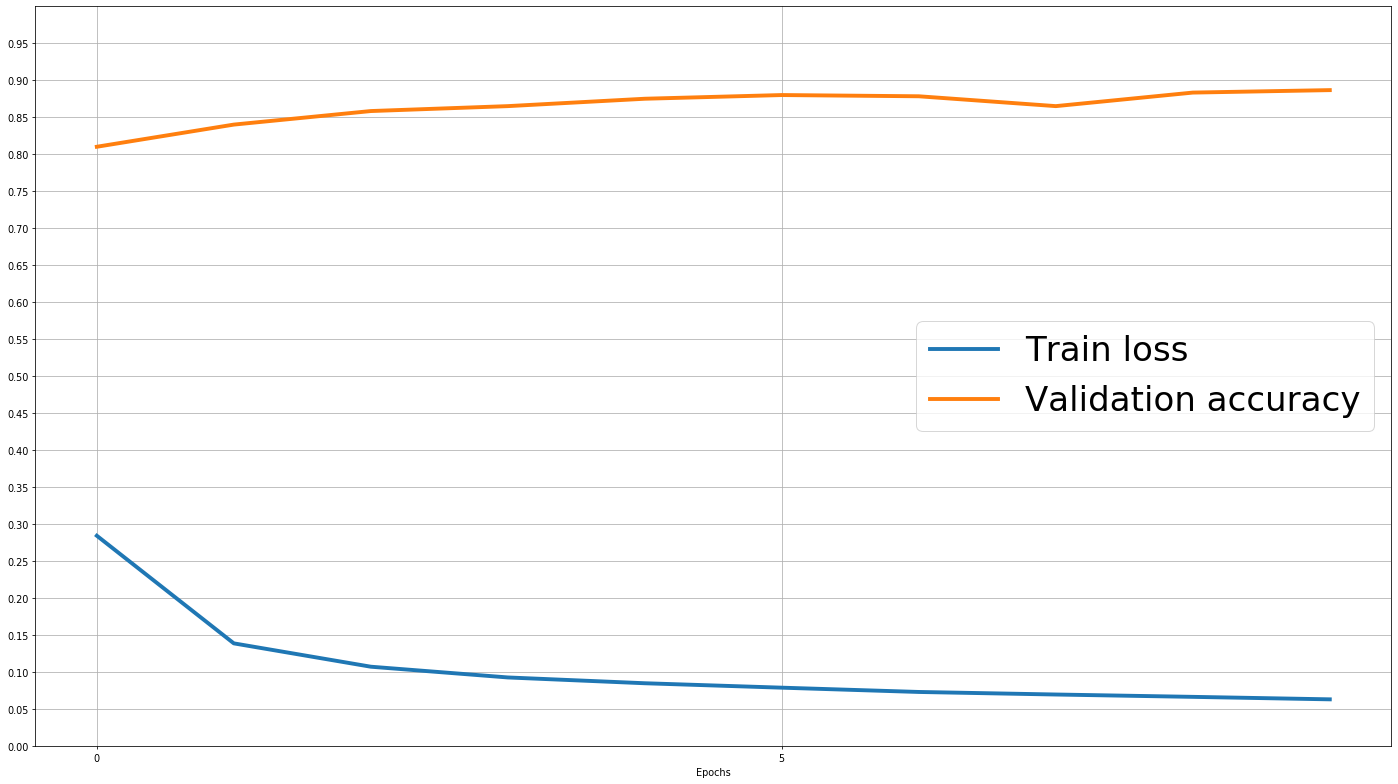

In [15]:
X, Y = np.loadtxt('example_applications/MNIST/small_mnist/mnist_small_train_in.txt', delimiter=','),np.loadtxt(
    'example_applications/MNIST/small_mnist/mnist_small_train_out.txt', delimiter=',')
(X, Y), (Xval, Yval) = split(X, Y, train_frac=0.9)
Y = to_categorical(Y)  # needed for training

hidden_layer_act = ReLU()
layers = [
    Layer(X.shape[1], Linear()),
    Layer(150, hidden_layer_act),
    Layer(150, hidden_layer_act),
    Layer(10, Softmax())
         ]
nn = NeuralNetwork(layers)
nn.compile(SquaredLoss(), metric=accuracy)
history = nn.fit(X, Y, Xval, Yval, learning_rate=0.006, n_epochs=10, batch_size=10)
plot_loss_and_accuracy(history)

 # TESTING

In [16]:
Xtest, Ytest = np.loadtxt('example_applications/MNIST/small_mnist/mnist_small_test_in.txt', delimiter=','), np.loadtxt(
    'example_applications/MNIST/small_mnist/mnist_small_test_out.txt', delimiter=',')
_ = nn.print_predict(Xtest, Ytest)
# note that it's the TEST performance below

Epoch -1 - Train loss = 0.063, Val performance: 0.9004
